# E-Greedy and Bandit Algorithms

Bandit algorithms provide a way to optimize single competing actions in the shortest amount of time. Imagine you are attempting to find out which advert provides the best click through rate of which button provides the most sales. You could show two ads and count the number of clicks on each, over a one week period. But this means that many people would see a sub-optimal ad. Instead, you can learn over time and progressively shift the shown advert towards the one that is performing better. For more information see the references in the book.

## The Testing Environment

In this workshop I will leverage a bandit library to simulate the behaviour and provide the first algorithm that chooses an action. I do this to get you up and running quickly, and because bandits are not the core focus of this book.

First let me install the library and define the simulated behaviour of the users.


In [1]:
!pip install banditsbook==0.1.1 pandas==1.1.2 matplotlib==3.3.2 &2> /dev/null

In [2]:
from arms.bernoulli import BernoulliArm

# Define two adverts, with a probability of clicking from the users
# This is a simulation. Imagine that these are real ads.
arm0 = BernoulliArm(0.05)
arm1 = BernoulliArm(0.4)
arms = [arm0, arm1]

This is an important definition, which glosses over a few important aspects. Primarily, these simulations are responsible for providing a reward whenever the simulated person performs an action. Sometimes the reward is a 0, when they don't click, other times it's a 1 when they do. Look:

In [3]:
[arm1.draw() for _ in range(5)]

[1.0, 0.0, 1.0, 0.0, 0.0]

## Running the Experiment With a Random Algorithm

Now we have the "environment" simulated, we can run various algorithms to see how often the optimal action is presented to the user.

A great baseline is a random agent, so let's try that first.

But I need a bit of supporting code, because I'm not interested in raw decisions. I want to see how often button 2 was chosen. To do this, I will repeat the experiment 1000 times, and measure the proportion of time ad 2 was chosen.

In [4]:
import pandas as pd
from algorithms.epsilon_greedy.standard import EpsilonGreedy
from testing_framework.tests import test_algorithm

epsilon = 1 # Choose a random action every time
num_sims = 1000 # Number of repetitions
horizon = 250 # Length of experiment

df = pd.DataFrame() # Buffer
algo1 = EpsilonGreedy(epsilon, [], []) # Algorithm
sim_nums, times, chosen_arms, rewards, cumulative_rewards = test_algorithm(
        algo1, arms, num_sims, horizon) # Running the environment/algorithm via the library
arrays = [[epsilon] * num_sims * horizon, sim_nums, times] # Constructing the output array for aggregation
index = pd.MultiIndex.from_arrays(
        arrays, names=('epsilon', 'simulation', 'time'))
df_chosen_arm = pd.DataFrame(chosen_arms, index=index)
df_chosen_arm = df_chosen_arm.groupby(level=[0, 2]).sum() / num_sims # Aggregating to result in the proportion of time
df = df.append(df_chosen_arm) # Append to buffer.

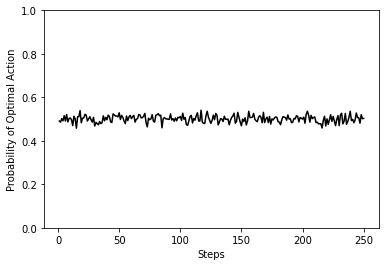

In [5]:
import matplotlib

df.loc[1].plot(legend=None,ylim=[0,1],ylabel="Probability of Optimal Action",xlabel="Steps",color="k");

As you can see, the optimal action is being selected half of the time, on average. This is the expected result for a random agent with two actions.

## Running the Experiment with Several Algorithms

Now let's try and repeat with several different values of epsilon, the value that chooses the amount of time the algorithm chooses a random action. An epsilon of 0 would never choose a random action.

In [6]:
df = pd.DataFrame()
for epsilon in [0, 0.1, 0.5, 1]:
    algo1 = EpsilonGreedy(epsilon, [], [])
    sim_nums, times, chosen_arms, rewards, cumulative_rewards = test_algorithm(
        algo1, arms, num_sims, horizon)

    arrays = [[epsilon] * num_sims * horizon, sim_nums, times]
    index = pd.MultiIndex.from_arrays(
        arrays, names=('epsilon', 'simulation', 'time'))
    df_chosen_arm = pd.DataFrame(chosen_arms, index=index)
    df_chosen_arm = df_chosen_arm.groupby(level=[0, 2]).sum() / num_sims
    df = df.append(df_chosen_arm)

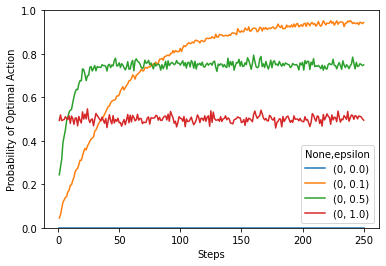

In [7]:
df.unstack(level=0).plot(ylim=[0,1],ylabel="Probability of Optimal Action",xlabel="Steps");

Now there are several plots with different values of epsilon. You can see that when epsilon (the probability of exploration) is zero, then the agent never picks the optimal action. This is a bit of an implementation bug. The first time the agent picks an agent, it should be random. Eventualy, one of those actions is rewarding and it will subsequently pick the same action over an over again, without exploring other options.

Another thing you will notice is the speed of convergence. The less exploration there is, the longer it will take to reach an optimal value.